# Extract features to XLSX

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.fftpack import dct

def calculate_mfcc_scipy(file_path, n_mfcc=13, n_mels=40, target_sample_rate=22000, fft_size=2048, hop_size=512):
    """
    Berechnet die MFCCs eines WAV-Files und gibt die Durchschnittswerte zurück.
    Args:
        file_path (str): Pfad zur Audio-Datei.
        n_mfcc (int): Anzahl der MFCC-Koeffizienten.
        n_mels (int): Anzahl der Mel-Bänder.
        target_sample_rate (int): Ziel-Abtastrate.
        fft_size (int): Größe des FFT-Fensters.
        hop_size (int): Schrittgröße zwischen den FFT-Fenstern.
    Returns:
        list: Durchschnittswerte der MFCCs.
    """
    # Lade das Audiofile
    sample_rate, data = wavfile.read(file_path)
    
    # Resampling prüfen
    if sample_rate != target_sample_rate:
        raise ValueError(f"Unexpected sample rate {sample_rate}. Expected {target_sample_rate}.")
    
    # Mono prüfen
    if len(data.shape) == 2:
        data = np.mean(data, axis=1)
    
    # Frame-Wise FFT
    frames = np.array([
        data[i:i+fft_size] * np.hamming(fft_size)
        for i in range(0, len(data) - fft_size, hop_size)
    ])
    magnitude = np.abs(np.fft.rfft(frames, axis=1))

    # Frequenzachse
    frequencies = np.fft.rfftfreq(fft_size, d=1/sample_rate)
    
    # Mel-Filterbank erstellen
    mel_filterbank = mel_filter_banks(sample_rate, fft_size, n_mels, frequencies)
    mel_power = np.dot(magnitude**2, mel_filterbank.T)

    # Logarithmische Skalierung
    log_mel = np.log(mel_power + 1e-10)

    # Diskrete Kosinustransformation (DCT) zur Reduktion
    mfccs = dct(log_mel, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    # Durchschnittswerte der MFCCs berechnen
    mean_mfccs = np.mean(mfccs, axis=0)
    return mean_mfccs

def mel_filter_banks(sample_rate, fft_size, n_mels, frequencies):
    """
    Erstellt ein Mel-Filterbank.
    """
    min_hz = 0
    max_hz = sample_rate // 2
    mel_min = 2595 * np.log10(1 + min_hz / 700)
    mel_max = 2595 * np.log10(1 + max_hz / 700)
    mel_points = np.linspace(mel_min, mel_max, n_mels + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    
    # Frequenz-Bins für die Filterbank
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)

    # Mel-Filterbank
    filterbank = np.zeros((n_mels, len(frequencies)))
    for i in range(1, n_mels + 1):
        start, center, end = bin_points[i - 1], bin_points[i], bin_points[i + 1]
        filterbank[i - 1, start:center] = (frequencies[start:center] - frequencies[start]) / (frequencies[center] - frequencies[start])
        filterbank[i - 1, center:end] = (frequencies[end] - frequencies[center:end]) / (frequencies[end] - frequencies[center])
    return filterbank

def process_audio_directory_scipy(input_directory, output_file, n_mfcc=13):
    """
    Berechnet MFCC-Durchschnittswerte für alle WAV-Dateien in einem Verzeichnis und speichert sie in einer Excel-Datei.
    Args:
        input_directory (str): Verzeichnis mit den Audio-Dateien.
        output_file (str): Pfad zur Ausgabedatei (Excel).
        n_mfcc (int): Anzahl der MFCC-Koeffizienten.
    """
    results = []
    for file_name in os.listdir(input_directory):
        if file_name.endswith(".wav"):
            file_path = os.path.join(input_directory, file_name)
            try:
                mfcc_means = calculate_mfcc_scipy(file_path, n_mfcc=n_mfcc)
                results.append({
                    'file': os.path.basename(file_path).replace('.wav', ''),  # Entfernt die .wav Endung
                    **{f'mfcc_{i+1}': value for i, value in enumerate(mfcc_means)}
                })
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    
    # Speichere die Ergebnisse in einer Excel-Datei
    df = pd.DataFrame(results)
    df.to_excel(output_file, index=False)
    print(f"MFCC-Durchschnittswerte gespeichert in: {output_file}")

# Beispiel: Berechnung für ein Verzeichnis
input_directory = "/Users/jakob/Downloads/IDMT_Traffic/preprocessed_audio"  # Pfad zu den WAV-Dateien
output_file = "/Users/jakob/Library/CloudStorage/OneDrive-student.kit.edu/Studium/02_Master/4. Semester/seminar/RTN-jakob/mfcc_features_scipy.xlsx"
process_audio_directory_scipy(input_directory, output_file)

MFCC-Durchschnittswerte gespeichert in: /Users/jakob/Library/CloudStorage/OneDrive-student.kit.edu/Studium/02_Master/4. Semester/seminar/RTN-jakob/mfcc_features_scipy.xlsx


# Merge df_stft.xlsx with df_dataset.xlsx

In [3]:
import pandas as pd

# Load datasets
df_dataset = pd.read_excel("df_dataset.xlsx")
mfcc_features_scipy = pd.read_excel("mfcc_features_scipy.xlsx")

# Merge datasets on 'file' column (left join to retain all rows in df_dataset)
df_merged = pd.merge(df_dataset, mfcc_features_scipy, on="file", how="left")

# Save the merged dataset
df_merged.to_excel("df_dataset_mfcc_merged.xlsx", index=False)
print("Merged dataset saved as df_dataset_mfcc_merged.xlsx")

Merged dataset saved as df_dataset_mfcc_merged.xlsx


add mean

In [4]:
import pandas as pd

# Define the input and output file paths
file_path = r'/Users/jakob/Library/CloudStorage/OneDrive-student.kit.edu/Studium/02_Master/4. Semester/seminar/RTN-jakob/df_dataset_mfcc_merged.xlsx'

# Load the Excel file
df = pd.read_excel(file_path)

# Identify MFCC columns (assumes they are named like 'mfcc_1', 'mfcc_2', etc.)
mfcc_columns = [col for col in df.columns if col.startswith('mfcc_')]

# Calculate the mean of MFCC columns for each row
df['mfcc_mean'] = df[mfcc_columns].mean(axis=1)

# Save the updated dataset back to the same Excel file
df.to_excel(file_path, index=False)
print(f"Updated dataset with 'mfcc_mean' saved to: {file_path}")

Updated dataset with 'mfcc_mean' saved to: /Users/jakob/Library/CloudStorage/OneDrive-student.kit.edu/Studium/02_Master/4. Semester/seminar/RTN-jakob/df_dataset_mfcc_merged.xlsx


In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the dataset
file_path = r'/Users/jakob/Library/CloudStorage/OneDrive-student.kit.edu/Studium/02_Master/4. Semester/seminar/RTN-jakob/df_dataset_mfcc_merged.xlsx'
df = pd.read_excel(file_path)

# Apply filters
df = df[(df['vehicle'].notna()) & (df['microphone'] == "SE")]

# Define speeds to iterate
speeds = [30, 50, 70]

# Create a subplot grid: 1 row and 3 columns (one for each speed)
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[f"MFCC Mean - {speed} km/h" for speed in speeds],
    horizontal_spacing=0.05
)

# Loop through columns (speeds) to add box plots
for col, speed in enumerate(speeds, start=1):
    # Filter data for the current speed
    df_filtered = df[df['speed_kmh'] == str(speed)]
    
    # Add box plots for each vehicle category
    fig.add_trace(
        go.Box(
            x=df_filtered['vehicle'],
            y=df_filtered['mfcc_mean'],
            name=f"{speed} km/h",
            boxmean=True  # Show mean in the box plot
        ),
        row=1, col=col
    )

# Update layout for better spacing and aesthetics
fig.update_layout(
    title_text="MFCC Mean Across Vehicle Categories and Speeds",
    height=400,  # Adjust for 1 row
    width=1200,  # Adjust for side-by-side plots
    xaxis_title="Vehicle Categories",
    yaxis_title="MFCC Mean",
    showlegend=False  # Hide redundant legend
)

# Show the figure
fig.show()

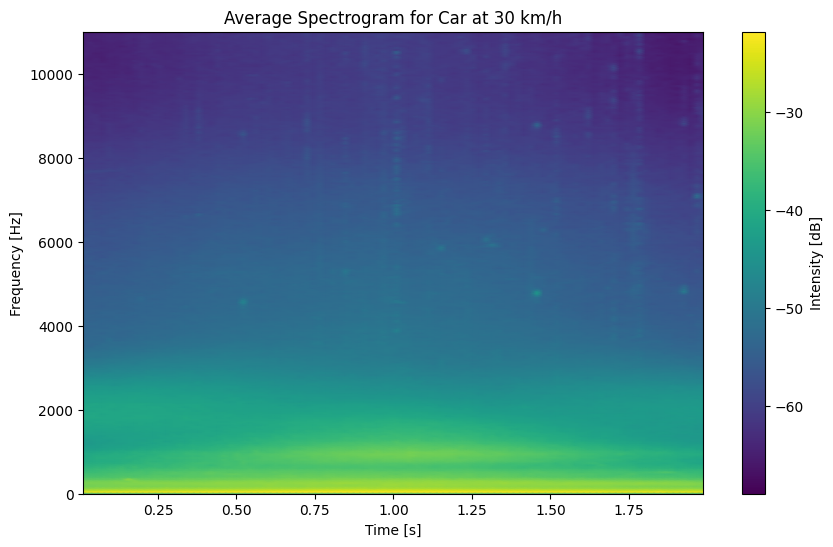

In [1]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Lade den Datensatz
file_path = r'/Users/jakob/Library/CloudStorage/OneDrive-student.kit.edu/Studium/02_Master/4. Semester/seminar/RTN-jakob/df_dataset_mfcc_merged.xlsx'
df = pd.read_excel(file_path)

# Filtere für Fahrzeugtyp "Car" und Geschwindigkeit "30"
df_filtered = df[(df['vehicle'] == 'C') & (df['speed_kmh'] == '30')]

# Verzeichnis mit den zugehörigen Audio-Dateien
audio_directory = "/Users/jakob/Downloads/IDMT_Traffic/preprocessed_audio"

# Liste für gespeicherte Spectrogramme
spectrograms = []

# Berechne Spectrogramme für jede Datei in der gefilterten Liste
for file_name in df_filtered['file']:
    file_path = f"{audio_directory}/{file_name}.wav"  # Pfad zur Datei
    sample_rate, data = wavfile.read(file_path)
    
    if data.ndim == 2:  # Falls Stereo, konvertiere zu Mono
        data = np.mean(data, axis=1)
    
    # Berechne das Spectrogramm
    f, t, Sxx = spectrogram(data, fs=sample_rate, nperseg=512)
    spectrograms.append(Sxx)

# Mittelung der Spectrogramme
average_spectrogram = np.mean(spectrograms, axis=0)

# Plot des durchschnittlichen Spectrogramms
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 10 * np.log10(average_spectrogram), shading='gouraud')
plt.colorbar(label='Intensity [dB]')
plt.title('Average Spectrogram for Car at 30 km/h')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

In [4]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.signal import spectrogram
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the dataset
file_path = r'/Users/jakob/Library/CloudStorage/OneDrive-student.kit.edu/Studium/02_Master/4. Semester/seminar/RTN-jakob/df_dataset_mfcc_merged.xlsx'
df = pd.read_excel(file_path)

# Audio directory path
audio_directory = "/Users/jakob/Downloads/IDMT_Traffic/preprocessed_audio"

# Vehicle classes and speeds
vehicles = ['C', 'B', 'T']  # Car, Bus, Truck
speeds = ['30', '50', '70']

# Function to calculate average spectrogram
def calculate_average_spectrogram(df_filtered, audio_directory):
    spectrograms = []
    for file_name in df_filtered['file']:
        file_path = f"{audio_directory}/{file_name}.wav"  # Path to the audio file
        sample_rate, data = wavfile.read(file_path)
        
        if data.ndim == 2:  # Convert stereo to mono
            data = np.mean(data, axis=1)
        
        # Calculate spectrogram
        _, _, Sxx = spectrogram(data, fs=sample_rate, nperseg=512)
        spectrograms.append(Sxx)
    
    # Average the spectrograms
    if len(spectrograms) > 0:
        return np.mean(spectrograms, axis=0)
    else:
        return None

# Create a subplot grid: 3 rows (vehicles) x 3 columns (speeds)
fig = make_subplots(
    rows=len(vehicles), cols=len(speeds),
    subplot_titles=[
        f"{vehicle} - {speed} km/h" for vehicle in vehicles for speed in speeds
    ],
    horizontal_spacing=0.05, vertical_spacing=0.1
)

# Loop through vehicle classes and speeds
for row, vehicle in enumerate(vehicles):
    for col, speed in enumerate(speeds):
        # Filter the data for the specific vehicle class and speed
        df_filtered = df[(df['vehicle'] == vehicle) & (df['speed_kmh'] == speed)]
        
        # Calculate the average spectrogram
        average_spectrogram = calculate_average_spectrogram(df_filtered, audio_directory)
        
        if average_spectrogram is not None:
            f, t, _ = spectrogram(np.zeros(512), fs=22000, nperseg=512)  # Dummy frequencies and times
            fig.add_trace(
                go.Heatmap(
                    z=10 * np.log10(average_spectrogram),
                    x=t,
                    y=f,
                    colorscale='Viridis',
                    showscale=(row == 0 and col == 0),  # Show colorbar only for the first plot
                    colorbar=dict(title="Intensity [dB]")
                ),
                row=row + 1,
                col=col + 1
            )
        else:
            fig.add_trace(
                go.Heatmap(
                    z=[[0]],  # Empty plot for "No Data"
                    x=[0],
                    y=[0],
                    colorscale='Viridis',
                    showscale=False
                ),
                row=row + 1,
                col=col + 1
            )

# Update layout for the subplot grid
fig.update_layout(
    title="Average Spectrograms for Vehicle Classes and Speeds",
    height=900,  # Adjust height
    width=1200,  # Adjust width
    xaxis_title="Time [s]",
    yaxis_title="Frequency [Hz]"
)

# Show the figure
fig.show()
